In [1]:
import gym
import random
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
from collections      import deque
from keras.models     import Sequential
from keras.layers     import Dense, Activation, Conv2D, Input, Lambda, Flatten, Permute
from keras.optimizers import Adam, SGD, RMSprop
import keras.backend as K
from tqdm import tqdm
import cv2

Using TensorFlow backend.


# Agent

In [54]:
def softmax(X):
    exp = np.exp(X)
    return exp / np.sum(exp, axis=-1, keepdims=True)

In [57]:
INPUT_SHAPE = (84, 84)
WINDOW_LENGTH = 4

class Agent:
    
    def __init__(self, action_size, weight_path):
        input_shape = (WINDOW_LENGTH,) + INPUT_SHAPE
        self.model = Sequential()

        # (width, height, channels)
        self.model.add(Permute((2, 3, 1), input_shape=input_shape))
        self.model.add(Conv2D(32, (8, 8), strides=(4, 4)))
        self.model.add(Activation('relu'))
        self.model.add(Conv2D(64, (4, 4), strides=(2, 2)))
        self.model.add(Activation('relu'))
        self.model.add(Conv2D(64, (3, 3), strides=(1, 1)))
        self.model.add(Activation('relu'))
        self.model.add(Flatten())
        self.model.add(Dense(512))
        self.model.add(Activation('relu'))
        self.model.add(Dense(action_size))
        self.model.add(Activation('linear'))
        #print(self.model.summary())
        #model.summary()
        
        self.model.compile(Adam(lr=.00025), loss='mae')
        self.model.load_weights(weight_path)
        
    
    def process_observation(self, observation):
        #assert observation.ndim == 3  # (height, width, channel)
        img = Image.fromarray(observation)
        img = img.resize(INPUT_SHAPE).convert('L')  # resize and convert to grayscale
        processed_observation = np.array(img)
        assert processed_observation.shape == INPUT_SHAPE
        return processed_observation.astype('uint8')  # saves storage in experience memory
    
    def process_state_batch(self, batch):
        # We could perform this processing step in `process_observation`. In this case, however,
        # we would need to store a `float32` array instead, which is 4x more memory intensive than
        # an `uint8` array. This matters if we store 1M observations.
        processed_batch = batch.astype('float32') / 255.
        return processed_batch
    
    def fit(self, X):
        pass
    
    def process_current_state(self, X):
        batch = []
        for x in X:
            state = []
            #state.append(self.process_observation(x[:210, :160, :].astype('uint8')))
            #state.append(self.process_observation(x[:210, 160:, :].astype('uint8')))
            #state.append(self.process_observation(x[210:, :160, :].astype('uint8')))
            #state.append(self.process_observation(x[210:, 160:, :].astype('uint8')))
            state.append(self.process_observation(x[210:, 160:, :].astype('uint8')))
            state.append(self.process_observation(x[210:, :160, :].astype('uint8')))
            state.append(self.process_observation(x[:210, 160:, :].astype('uint8')))
            state.append(self.process_observation(x[:210, :160, :].astype('uint8')))
            
            batch.append(state)
        batch = self.process_state_batch(np.array(batch))
        return batch
    
    def predict(self, X):
        batch = self.process_current_state(X)
        pred = self.model.predict(batch)
        #print('batch2 : ', batch.shape)
        #
        #print('pred shape: ', pred.shape)
        #print(type(pred))
        return softmax(pred)
    
    def next_action(self, X):
        return np.argmax(self.predict(X)[0])

# Env

In [58]:
env = gym.make('Breakout-v4')
np.random.seed(123)
env.seed(123)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

In [65]:
weight_path = "DQN/weights/dqn_Breakout-v4_weights_10000000.h5f"
agent = Agent(action_size, weight_path)

## Test

In [12]:
s1 = env.reset()
s2, _, _, _ = env.step(1)
s3, _, _, _  = env.step(2)
s4, _, _, _  = env.step(2)

a = np.zeros((420, 320, 3))
a[:210, :160, :] = s1
a[:210, 160:, :] = s2
a[210:, :160, :] = s3
a[210:, 160:, :] = s4
#a = a.astype(int)

In [19]:
from lime import lime_image

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(a, agent.predict, top_labels=1, hide_color=0, num_samples=1000)

In [20]:
action = np.argmax(agent.predict([a])[0])

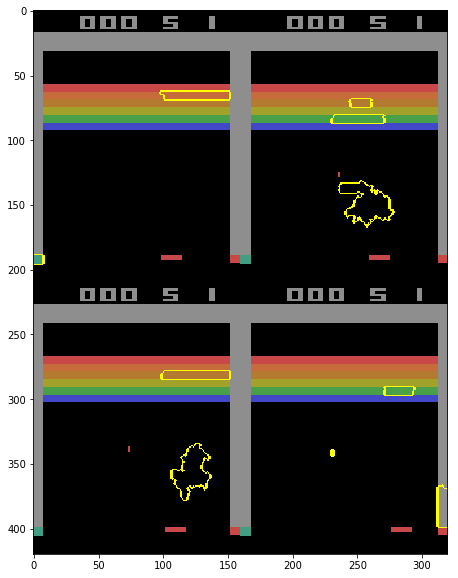

In [21]:
from skimage.segmentation import mark_boundaries

temp, mask = explanation.get_image_and_mask(action, positive_only=True, num_features=10, hide_rest=False)
plt.figure(figsize=(10,10))
plt.imshow(mark_boundaries(temp /255, mask))

In [60]:
def update_current_state(current_state, new_frame):
    current_state[210:, 160:, :] = current_state[210:, :160, :]
    current_state[210:, :160, :] = current_state[:210, 160:, :]
    current_state[:210, 160:, :] = current_state[:210, :160, :]
    current_state[:210, :160, :] = new_frame
    
    return current_state

In [61]:
def initialize_current_state(new_frame):
    current_state = np.zeros((420, 320, 3))
    current_state[:210, :160, :] = new_frame
    current_state[:210, 160:, :] = new_frame
    current_state[210:, :160, :] = new_frame
    current_state[210:, 160:, :] = new_frame
    
    return current_state


100%|██████████| 20/20 [00:00<00:00, 22.70it/s]

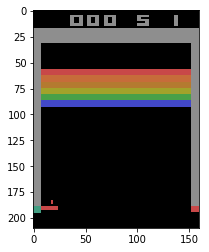

In [69]:
from IPython import display
state_frame = env.reset()
img = plt.imshow(state_frame)
current_state = initialize_current_state(state_frame)
for i in tqdm(range(20)):
    x = np.expand_dims(current_state, axis=0)
    action = agent.next_action(x)
    next_state, reward, done, _ = env.step(action)
    current_state = update_current_state(current_state, next_state)
    img.set_data(next_state)
    display.display(plt.gcf())
    display.clear_output(wait=True)


100%|██████████| 20/20 [06:46<00:00, 20.66s/it]


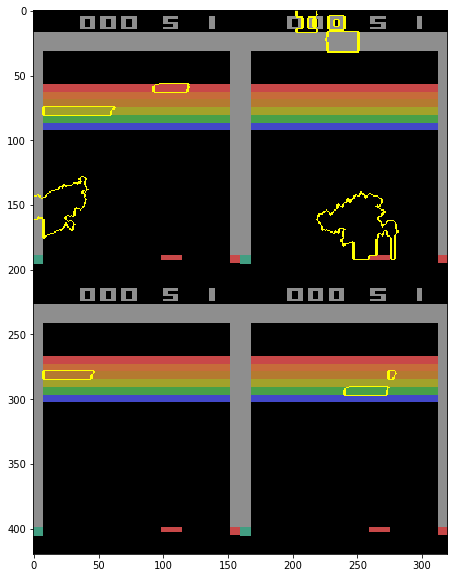

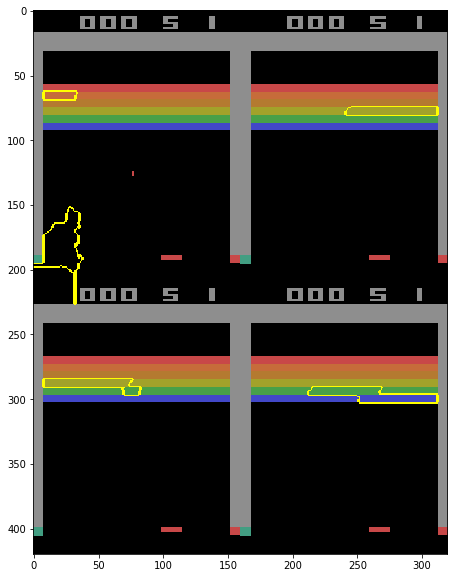

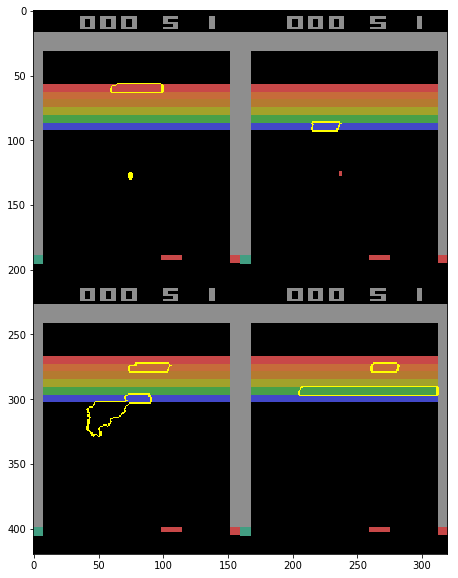

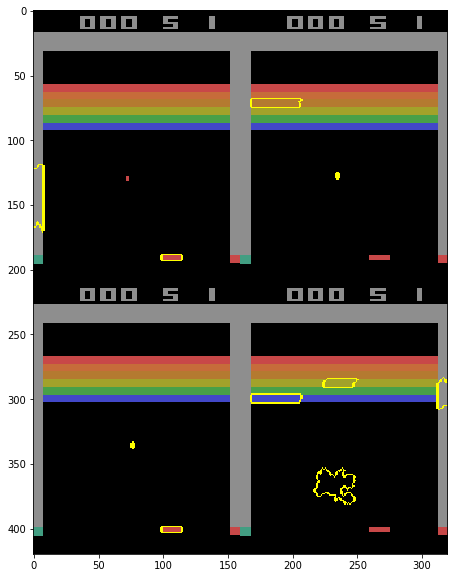

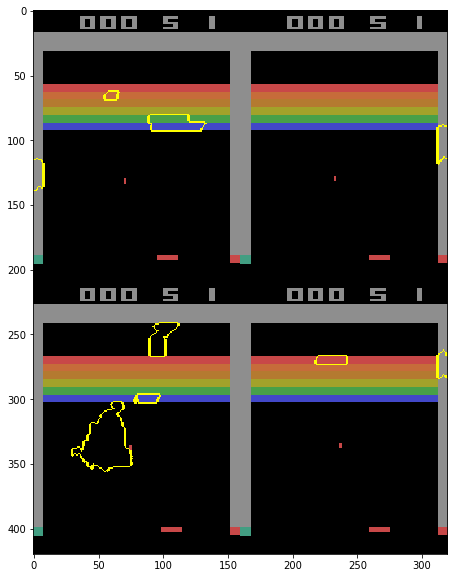

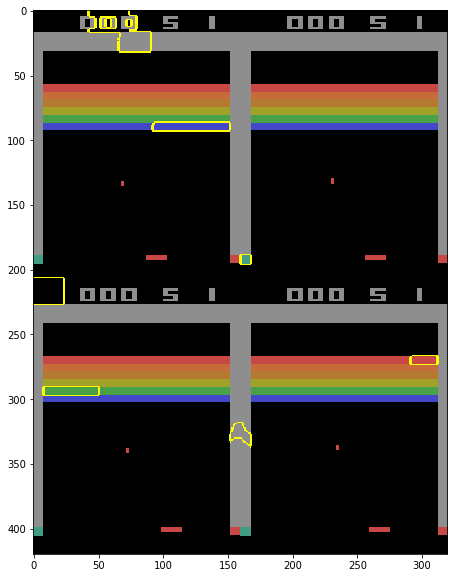

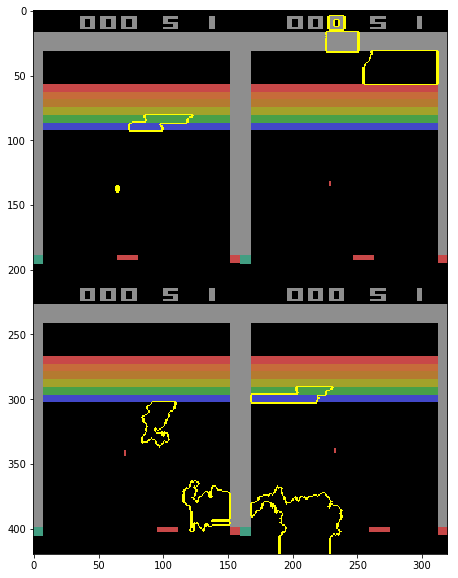

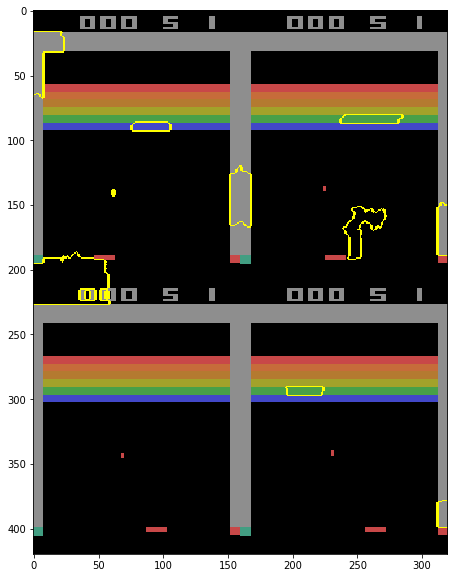

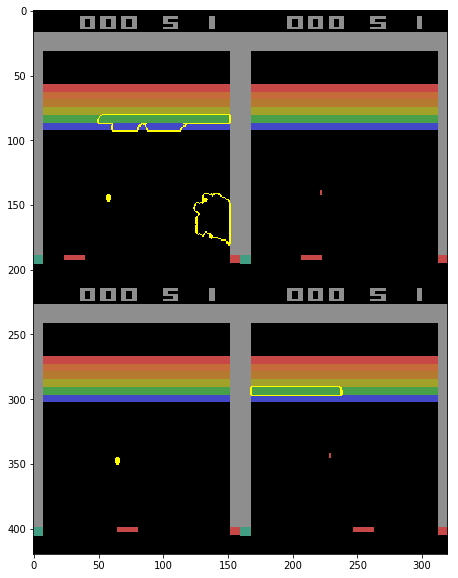

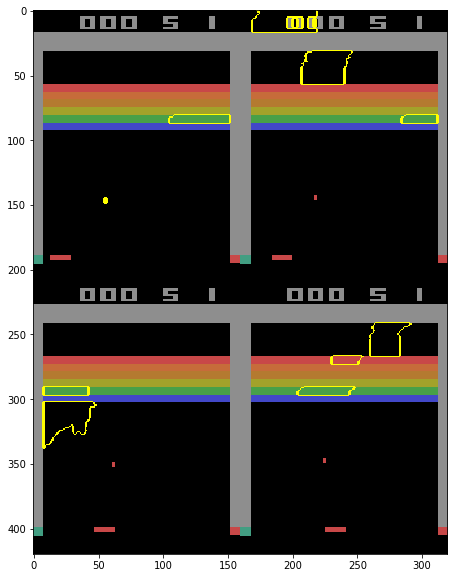

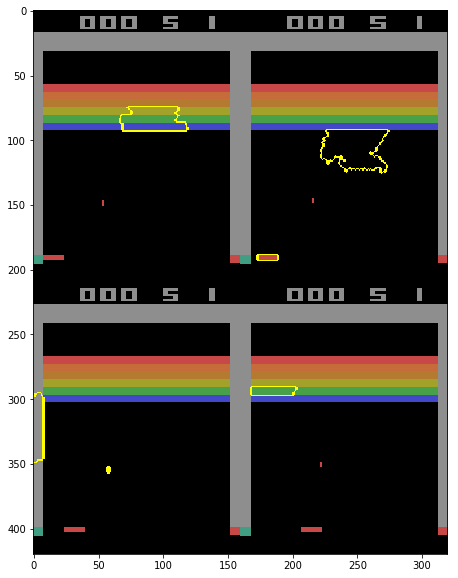

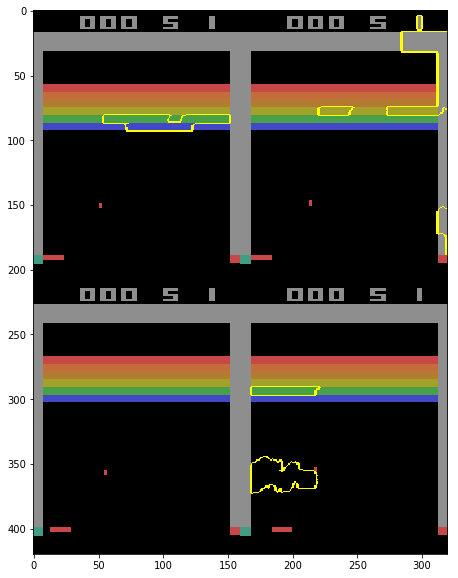

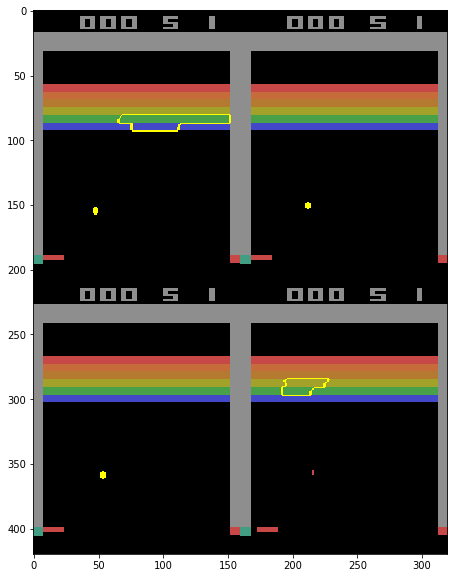

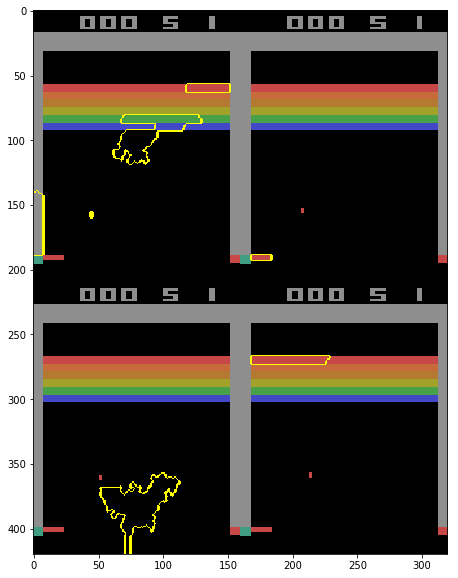

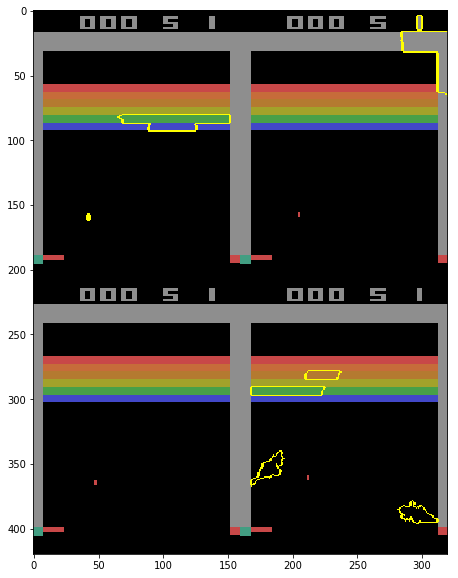

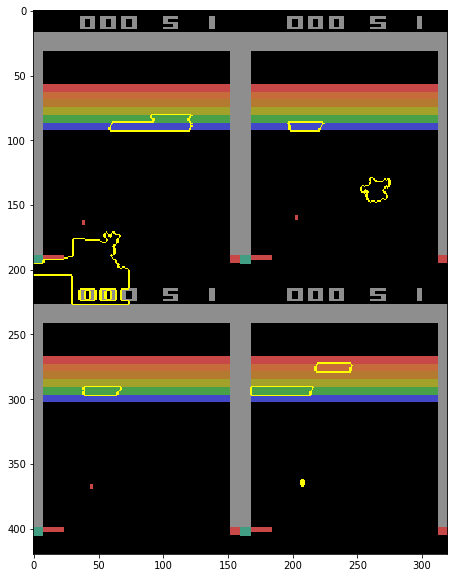

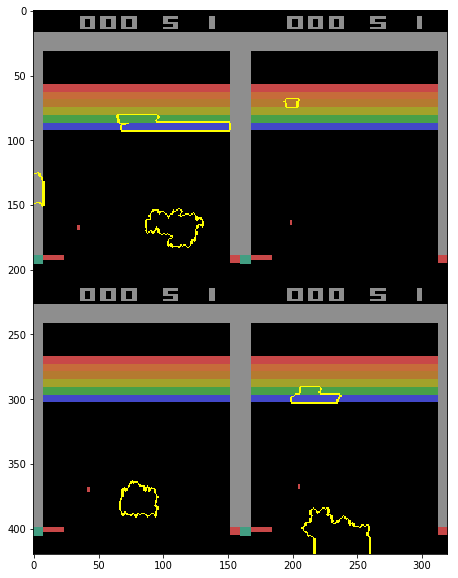

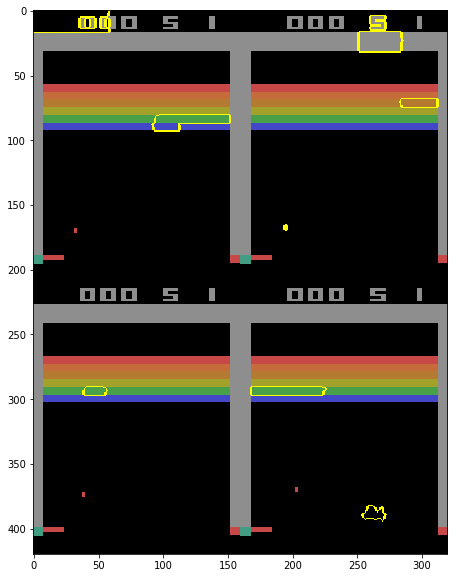

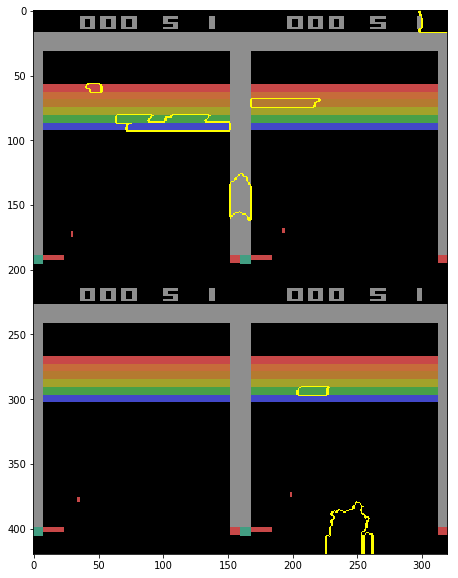

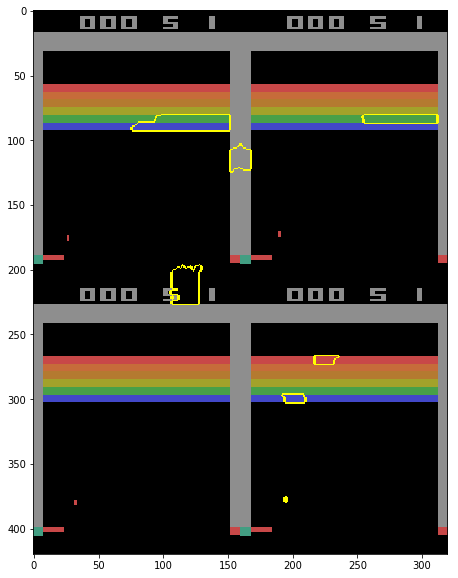

In [66]:
state_frame = env.reset()
current_state = initialize_current_state(state_frame)
for i in tqdm(range(20)):
    x = np.expand_dims(current_state, axis=0)
    action = agent.next_action(x)
    next_state, reward, done, _ = env.step(action)
    explanation = explainer.explain_instance(current_state, agent.predict, top_labels=1, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(action, positive_only=True, num_features=10, hide_rest=False)
    
    current_state = update_current_state(current_state, next_state)
    #plt.figure(figsize=(7,7))
    #plt.imshow(current_state.astype(int))
    #plt.title('frame ' + str(i))
    
    plt.figure(figsize=(10,10))
    plt.imshow(mark_boundaries(temp /255, mask))
    #env.render()


100%|██████████| 20/20 [06:45<00:00, 20.13s/it]


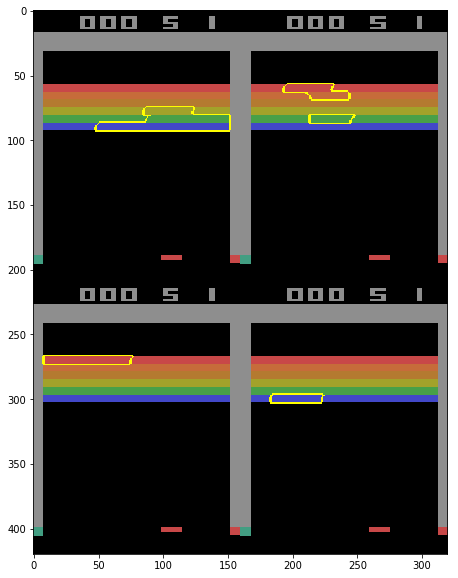

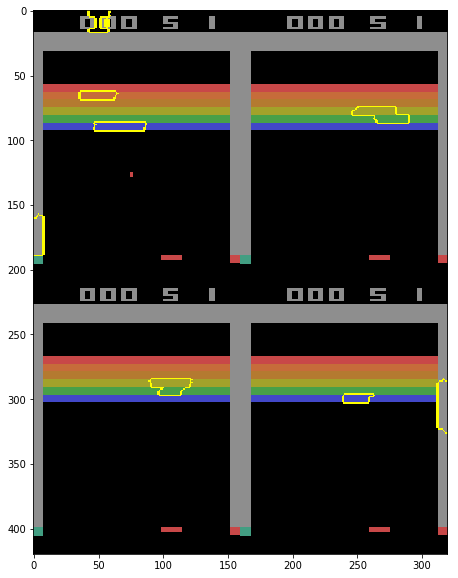

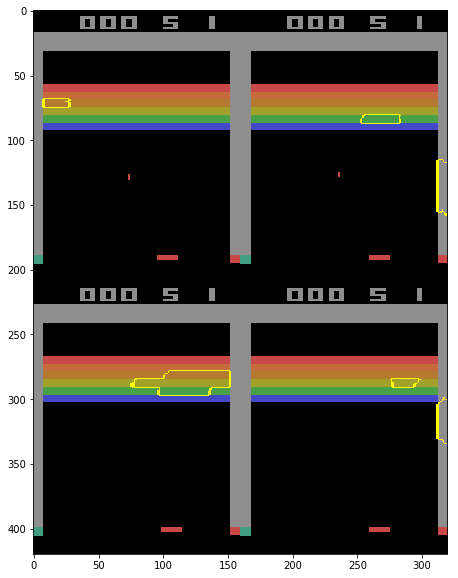

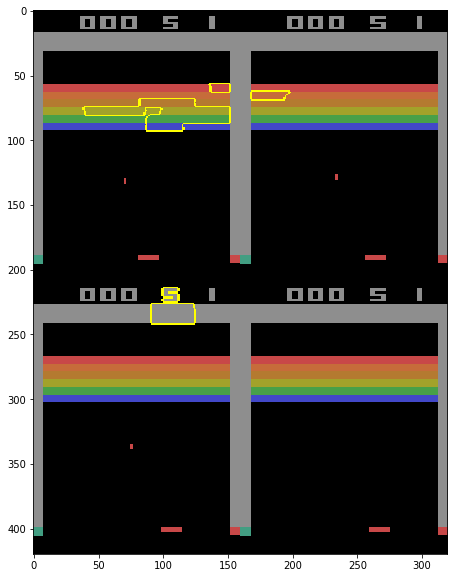

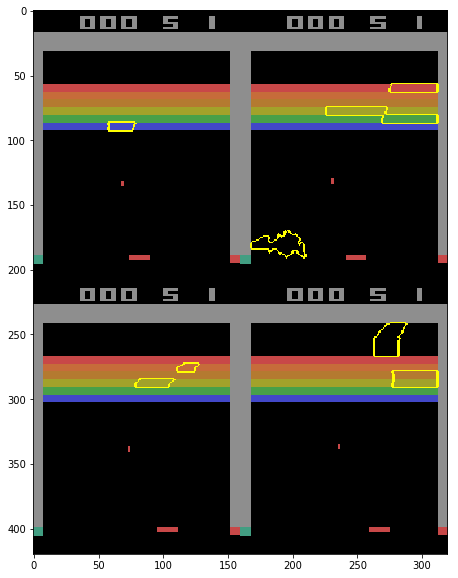

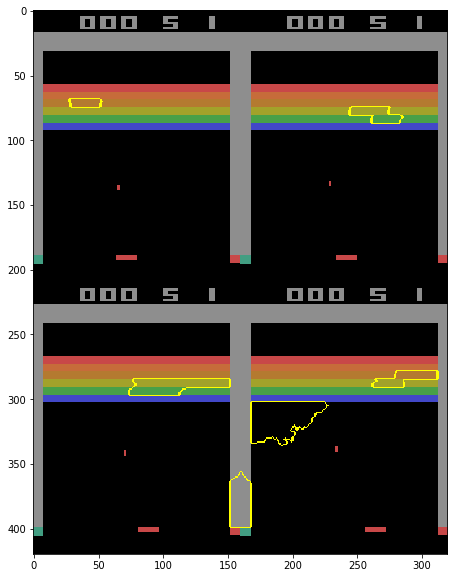

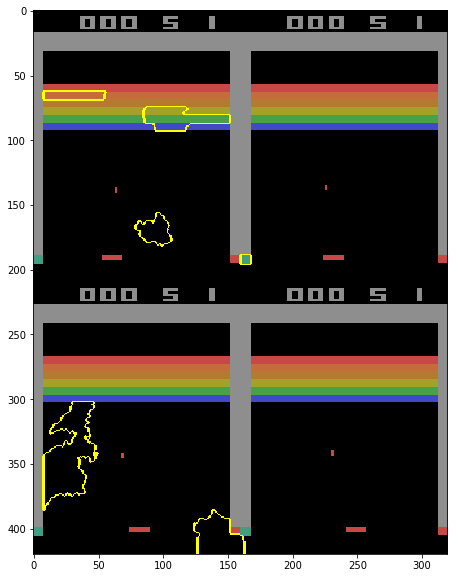

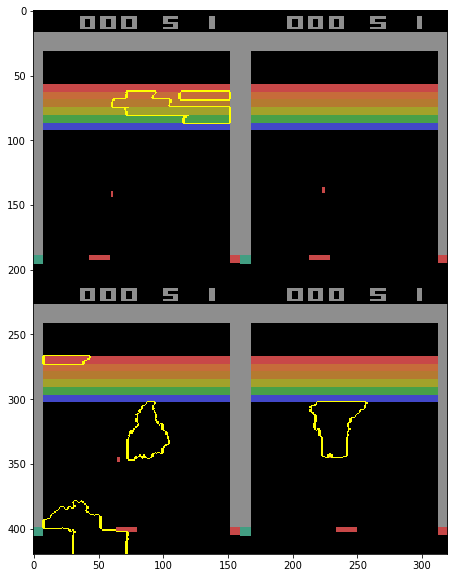

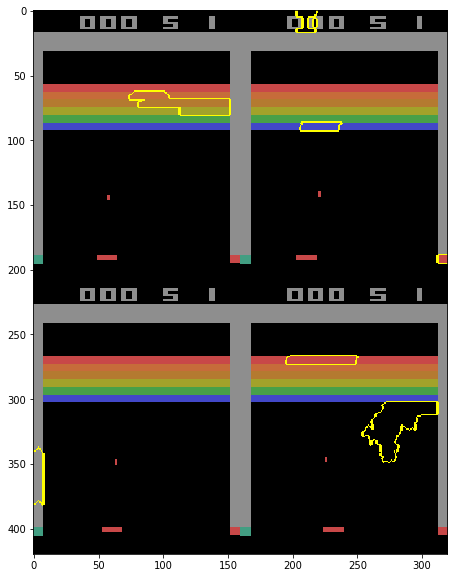

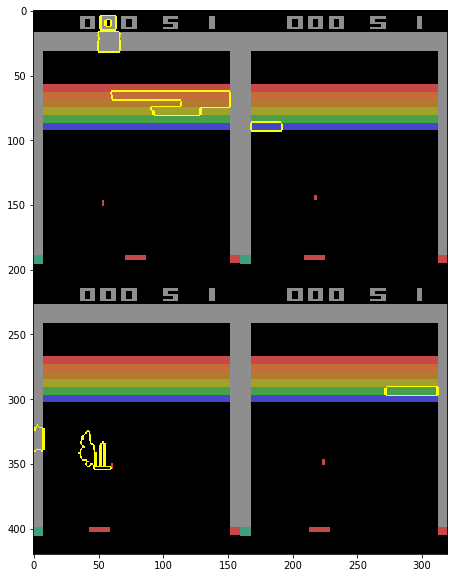

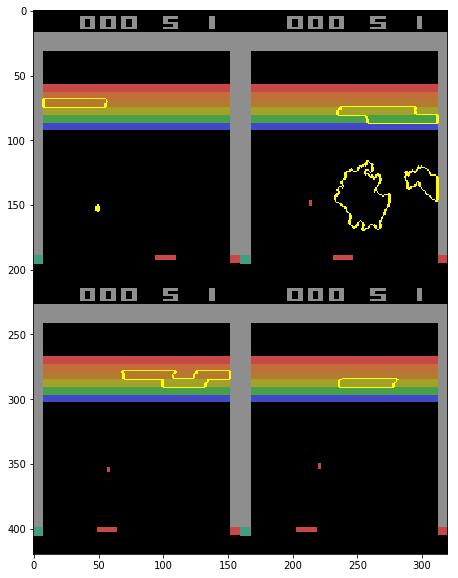

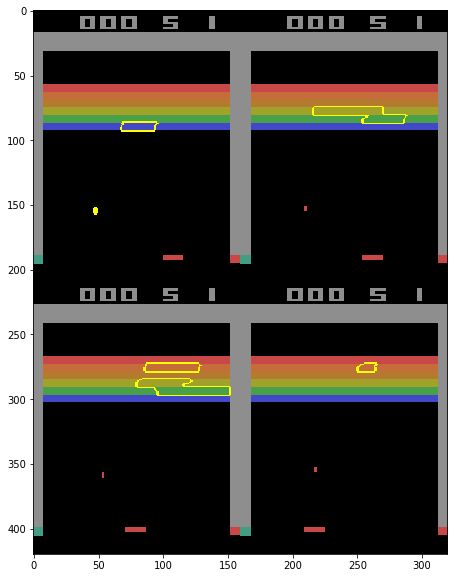

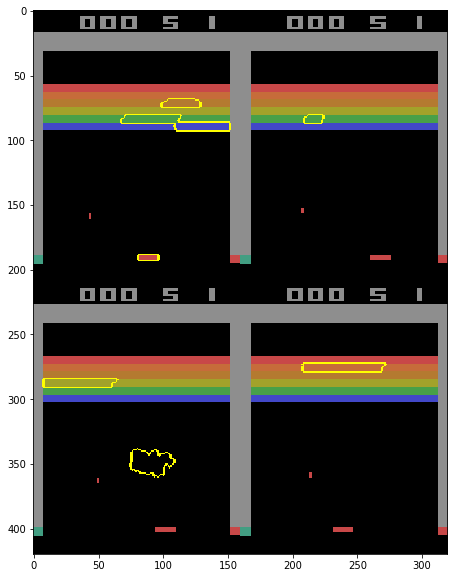

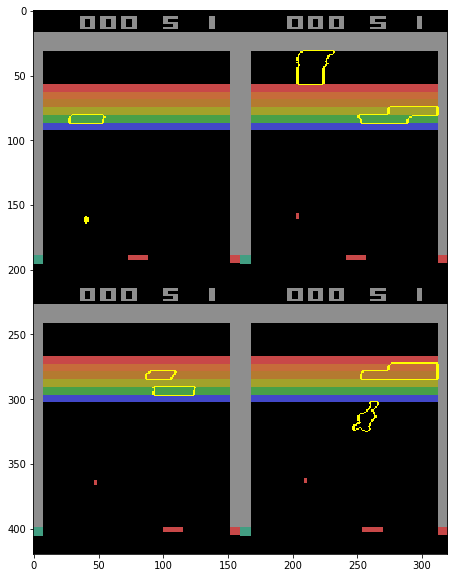

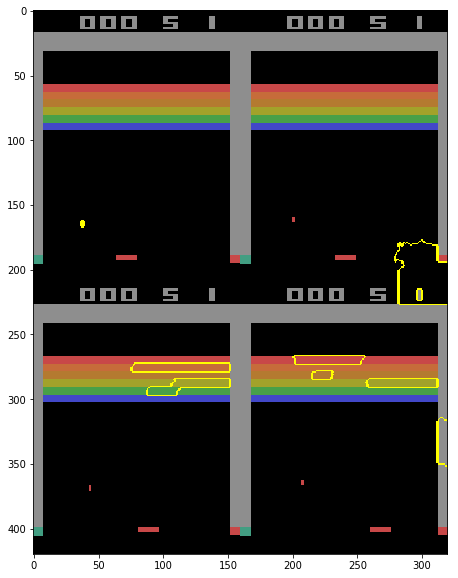

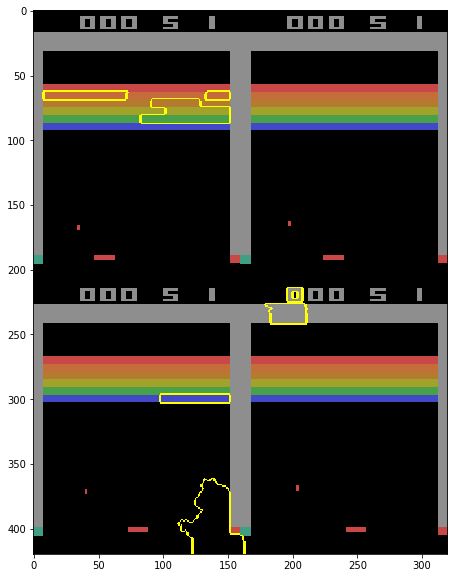

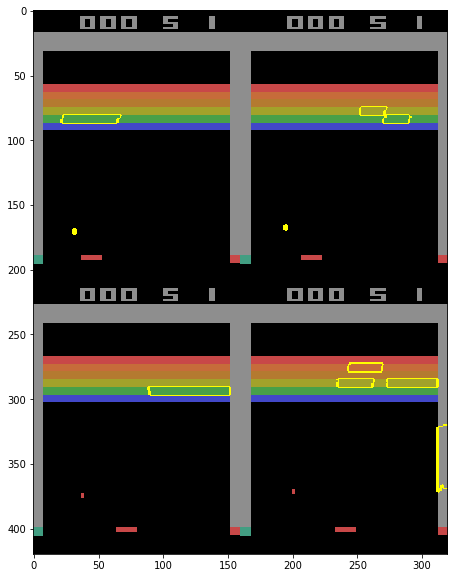

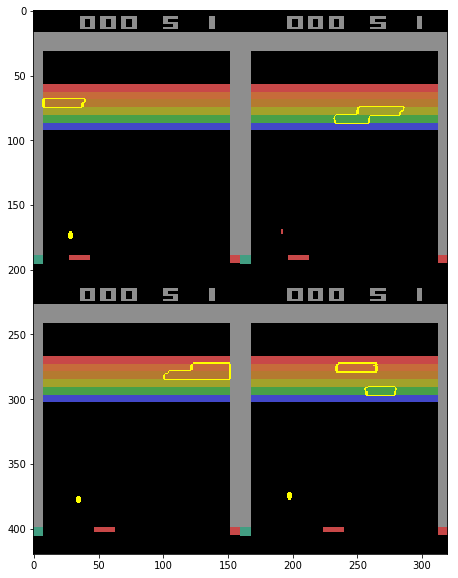

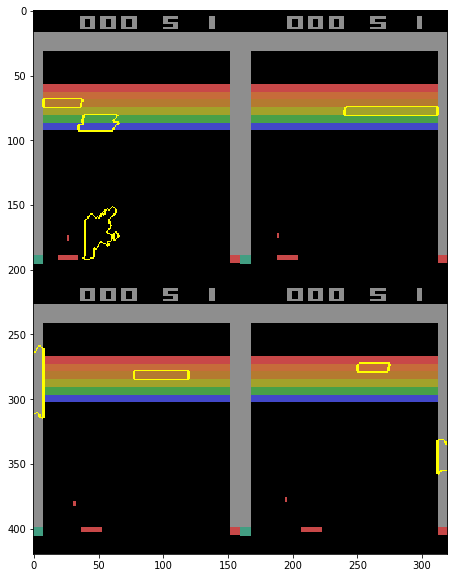

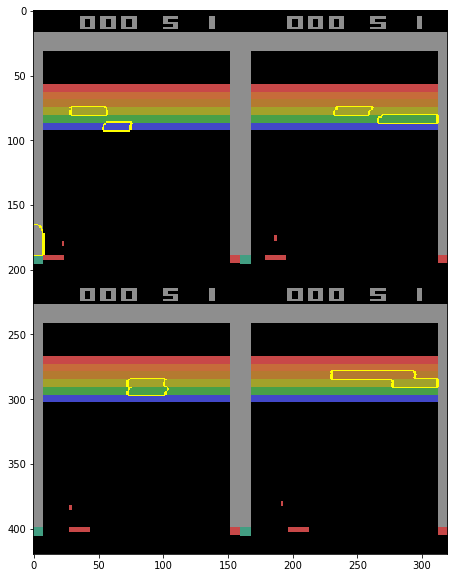

In [64]:
state_frame = env.reset()
current_state = initialize_current_state(state_frame)
for i in tqdm(range(20)):
    x = np.expand_dims(current_state, axis=0)
    action = agent.next_action(x)
    next_state, reward, done, _ = env.step(action)
    explanation = explainer.explain_instance(current_state, agent.predict, top_labels=1, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(action, positive_only=True, num_features=10, hide_rest=False)
    
    current_state = update_current_state(current_state, next_state)
    #plt.figure(figsize=(7,7))
    #plt.imshow(current_state.astype(int))
    #plt.title('frame ' + str(i))
    
    plt.figure(figsize=(10,10))
    plt.imshow(mark_boundaries(temp /255, mask))
    #env.render()